# Mean-CVaR and Entropy Pooling
This example walks through the mean-CVaR and Entropy Pooling functionality by illustrating how these two methods can be combined. For more information about Entropy Pooling and CVaR, see our articles https://ssrn.com/abstract=3936392, https://ssrn.com/abstract=4034316, https://ssrn.com/abstract=4217884, and https://ssrn.com/abstract=4444291.

You can see a video walkthrough of the example here: https://youtu.be/0BD0fxcsfLI.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import fortitudo.tech as ft
import matplotlib.pyplot as plt

In [2]:
# Load data and print prior P&L stats
R_df = ft.load_pnl()
stats_prior = ft.simulation_moments(R_df)
stats_prior.iloc[:, 0:2] = stats_prior.iloc[:, 0:2].mul(100)
display(np.round(stats_prior, 1))

,Mean,Volatility,Skewness,Kurtosis
Gov & MBS,-0.7,3.2,0.1,3.0
Corp IG,-0.4,3.4,0.1,3.1
Corp HY,1.9,6.1,0.2,3.0
EM Debt,2.7,7.5,0.2,3.1
DM Equity,6.4,14.9,0.4,3.1
EM Equity,8.0,26.9,0.8,4.1
Private Equity,13.7,27.8,0.7,3.8
Infrastructure,5.9,10.8,0.3,3.2
Real Estate,4.3,8.1,0.2,3.1
Hedge Funds,4.8,7.2,0.2,3.1


# Prior probability and portfolio constraints
The below portfolio constraints simply specify that it is a long-only portfolio with an upper bound of 25% for individual assets. This ensures that the optimized portfolios are invested in at least 4 assets and imposes some diversification.

The prior probability is simply taken to be uniform in this case, but other prior probability vectors can also be used. The only requirement is that all probabilities are strictly positive and sum to one.

In [3]:
S, I = R_df.shape
G_pf = np.vstack((np.eye(I), -np.eye(I)))
h_pf = np.hstack((0.25 * np.ones(I), np.zeros(I)))
p = np.ones((S, 1)) / S

# Optimization object
The next step is to input the P&L, constraints, and probability vector into a MeanCVaR object as well as optimize portfolios.

Note that if no equality constraints are specified through the matrix A and the vector b, the default constraint will be that the weights sum to one using the self-financing constraint from https://ssrn.com/abstract=4217884.

In [4]:
R = R_df.values
ft.cvar_options['demean'] = False
cvar_opt = ft.MeanCVaR(R, G=G_pf, h=h_pf, p=p)
w_min = cvar_opt.efficient_portfolio()
w_target = cvar_opt.efficient_portfolio(return_target=0.05)

# A note about the MeanCVaR class
Note that the MeanCVaR object uses demeaned P&L by default when optimizing the portfolio's CVaR. We believe it is best not to rely on the expected return estimates in both portfolio risk and portfolio mean, see the example that compares mean-CVaR and mean-variance optimization as well as https://ssrn.com/abstract=4034316 for a more thorough treatment of why we prefer demeaned CVaR. In the above example, we illustrate how you can disable this feature and specify that the optimization should compute portfolio CVaR including its expected return.

# Views with Entropy Pooling
Let us now assume that we have performed some analysis and concluded that the mean of Private Equity should be 10% while its volatility should be greater than or equal to 33%. Entropy Pooling allows us to incorporate this market view into our P&L assumption in a way that introduces the least amount of spurious structure, measured by the relative entropy between our prior and posterior probability vectors, see https://ssrn.com/abstract=3936392 for an introduction.

In [5]:
# Specify views and compute posterior probability vector
expected_return_row = R[:, 6][np.newaxis, :]
variance_row = (expected_return_row - 0.1)**2
A = np.vstack((np.ones((1, S)), expected_return_row))
b = np.array([[1], [0.1]])
G = -variance_row
h = np.array([[-0.33**2]])
q = ft.entropy_pooling(p, A, b, G, h)

# Print posterior stats
stats_post = ft.simulation_moments(R_df, q)
stats_post.iloc[:, 0:2] = stats_post.iloc[:, 0:2].mul(100)
display(np.round(stats_post, 1))

,Mean,Volatility,Skewness,Kurtosis
Gov & MBS,-0.5,3.2,0.1,3.0
Corp IG,-0.5,3.4,0.1,3.1
Corp HY,1.2,6.4,0.3,3.0
EM Debt,2.3,7.6,0.2,3.1
DM Equity,4.4,16.4,0.6,3.5
EM Equity,5.2,29.2,1.0,5.2
Private Equity,10.0,33.0,1.2,4.9
Infrastructure,5.1,11.1,0.3,3.2
Real Estate,3.6,8.5,0.3,3.1
Hedge Funds,3.8,8.0,0.4,3.4


We note that our views regarding Private Equity are satisfied. In addition, we note that volatilities of the riskier assets have increased, while their expected returns have decreased. This illustrates how Entropy Pooling incorporates views / stress-tests in a way that respects the dependencies of the prior distribution.

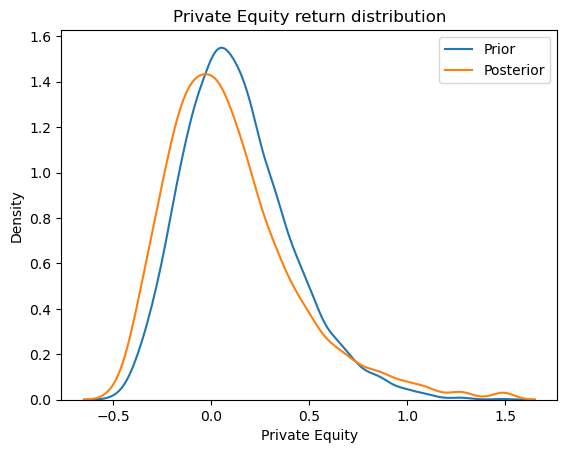

In [6]:
# Visualize Private Equity prior and posterior
sns.kdeplot(x=R_df['Private Equity'])
sns.kdeplot(x=R_df['Private Equity'], weights=q[:, 0])
plt.title('Private Equity return distribution')
plt.legend(['Prior', 'Posterior'])
plt.show()

# Optimization with posterior probabilities
With the posterior probabilities at hand, we want to examine the effect of our views on the efficient CVaR portfolios. This is easy to do by simply specifying that the posterior probability vector q should be used in the CVaR optimization. We then print the results of the optimizations and compare allocations.

In [7]:
cvar_opt_post = ft.MeanCVaR(R, G=G_pf, h=h_pf, p=q)
w_min_post = cvar_opt_post.efficient_portfolio()
w_target_post = cvar_opt_post.efficient_portfolio(return_target=0.05)

In [8]:
instrument_names = R_df.columns
min_risk_pfs = pd.DataFrame(
    data=np.hstack((w_min, w_min_post)),
    index=instrument_names,
    columns=['Prior', 'Posterior'])
display(np.round(min_risk_pfs * 100, 1))

,Prior,Posterior
Gov & MBS,25.0,25.0
Corp IG,25.0,25.0
Corp HY,0.5,6.5
EM Debt,3.9,5.0
DM Equity,0.0,0.0
EM Equity,-0.0,0.0
Private Equity,-0.0,-0.0
Infrastructure,6.9,6.9
Real Estate,14.5,17.7
Hedge Funds,24.2,14.0


In [9]:
target_return_pfs = pd.DataFrame(
    data=np.hstack((w_target, w_target_post)),
    index=instrument_names,
    columns=['Prior', 'Posterior'])
display(np.round(target_return_pfs * 100, 1))

,Prior,Posterior
Gov & MBS,0.0,-0.0
Corp IG,0.0,-0.0
Corp HY,0.0,0.0
EM Debt,19.8,8.1
DM Equity,0.0,0.0
EM Equity,0.0,0.0
Private Equity,5.2,16.9
Infrastructure,25.0,25.0
Real Estate,25.0,25.0
Hedge Funds,25.0,25.0


It should be straightforward to make sense of the above results. In the minimum risk case, we see that we allocate less to the riskier assets that now have a higher risk due to the higher volatility view. In the 5% target return case, we note that we must allocate more to the riskier assets in order to reach the 5% expected return target.

# Efficient frontier optimization
We can also compute efficient frontiers for the prior and posterior probabilities as illustrated below.

In [10]:
front = cvar_opt.efficient_frontier()
display(np.round(pd.DataFrame(100 * front, index=instrument_names), 1))
vol = ft.portfolio_vol(front, R, p)
var = ft.portfolio_var(front, R, p)
cvar = ft.portfolio_cvar(front, R, p)
risk_prior = np.vstack((vol, var, cvar))
display(np.round(pd.DataFrame(100 * risk_prior, index=['Vol', 'VaR', 'CVaR']), 1))

front_post = cvar_opt_post.efficient_frontier()
display(np.round(pd.DataFrame(100 * front_post, index=instrument_names), 1))
vol_post = ft.portfolio_vol(front, R, q)
var_post = ft.portfolio_var(front, R, q)
cvar_post = ft.portfolio_cvar(front, R, q)
risk_post = np.vstack((vol_post, var_post, cvar_post))
display(np.round(pd.DataFrame(100 * risk_post, index=['Vol', 'VaR', 'CVaR']), 1))

,0,1,2,3,4,5,6,7,8
Gov & MBS,25.0,25.0,18.8,5.6,0.0,-0.0,-0.0,0.0,-0.0
Corp IG,25.0,8.3,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
Corp HY,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EM Debt,3.9,9.6,12.8,18.1,17.4,12.7,7.1,0.0,-0.0
DM Equity,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.9,25.0
EM Equity,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.2,25.0
Private Equity,-0.0,-0.0,0.7,2.2,7.6,15.4,23.1,25.0,25.0
Infrastructure,6.9,12.9,18.9,24.1,25.0,25.0,25.0,25.0,25.0
Real Estate,14.5,19.2,23.9,25.0,25.0,21.9,19.9,2.0,0.0
Hedge Funds,24.2,25.0,25.0,25.0,25.0,25.0,25.0,25.0,0.0


,0,1,2,3,4,5,6,7,8
Vol,3.5,4.2,5.1,6.1,7.3,8.9,10.5,13.0,17.0
VaR,5.6,6.7,8.0,9.7,11.4,13.7,15.9,19.6,25.2
CVaR,7.0,8.2,9.9,11.9,14.0,16.5,19.1,23.3,29.8


,0,1,2,3,4,5,6,7,8
Gov & MBS,25.0,25.0,25.0,14.1,-0.0,0.0,-0.0,-0.0,-0.0
Corp IG,25.0,16.0,0.8,0.0,0.0,0.0,0.0,-0.0,-0.0
Corp HY,6.5,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0
EM Debt,5.0,6.9,13.5,14.3,23.3,15.6,8.0,0.3,0.0
DM Equity,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0
EM Equity,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0
Private Equity,-0.0,-0.0,0.0,0.0,1.7,9.4,17.0,24.7,25.0
Infrastructure,6.9,12.4,15.9,23.8,25.0,25.0,25.0,25.0,25.0
Real Estate,17.7,17.0,19.7,22.8,25.0,25.0,25.0,25.0,0.0
Hedge Funds,14.0,22.6,25.0,25.0,25.0,25.0,25.0,25.0,0.0


,0,1,2,3,4,5,6,7,8
Vol,3.8,4.5,5.5,6.7,8.2,10.2,12.2,15.2,19.6
VaR,5.9,6.9,8.5,10.2,12.3,14.7,17.1,20.8,26.7
CVaR,7.3,8.5,10.3,12.4,14.7,17.2,20.0,24.3,30.8


From the allocation results, we note that the portfolios suffer from the well-known issues of concentrated portfolios. There are several ways of  addressing this issue in practice, e.g., taking parameter uncertainty into account and introduce transaction costs, risk budgets, or turnover constraints with an initially diversified portfolio. These aspects are however beyond the scope of this example and package.

# License

In [11]:
# fortitudo.tech - Novel Investment Technologies.
# Copyright (C) 2021-2023 Fortitudo Technologies.

# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.